### Offline validation tendency profiles

In [1]:
import os
import xarray as xr
import fsspec
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

In [2]:
CASES = dict(
    nudged_prescribed_sfc_rad_precip_RF=['gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/rf/offline_diags/postphysics_ML_tendencies/offline_diagnostics.nc'],
    nudged_prescribed_sfc_rad_precip_NN=[
        'gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn-ensemble-model/offline_diags/dq1-dq2/offline_diagnostics.nc',
        'gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn-ensemble-model/offline_diags/dqu-dqv/offline_diagnostics.nc'
    ]
)

OUTPUTDIR = '.'

In [3]:
def open_diags(path):
    with fsspec.open(path, 'rb') as f:
        ds = xr.open_dataset(f).load()
    return ds

datasets = []
for case, paths in CASES.items():
    print(case)
    if len(paths) == 1:
        datasets.append(open_diags(paths[0]).assign_coords({'cases': case}))
    else:
        case_datasets = []
        for path in paths:
            case_datasets.append(open_diags(path))
        dataset = xr.merge(case_datasets, compat='override')         
        datasets.append(dataset.assign_coords({'cases': case}))
diags = xr.concat(datasets, dim="cases")

nudged_prescribed_sfc_rad_precip_RF
nudged_prescribed_sfc_rad_precip_NN


In [4]:
R2_VARS = [
    'dQ2',
    'dQ1',
    'dQu',
    'dQv'
]

def add_R2(ds):
    for var in R2_VARS:
        ds[f"pressure_level-R2-{var}"] = 1.0 - ds[f'pressure_level-mse-{var}-predict_vs_target']/ds[f'pressure_level-mse-{var}-mean_vs_target']
    return ds

diags = add_R2(diags)

In [8]:
def plot_R2_cases(da):
    fig, ax = plt.subplots(1, 1)
    if 'dQv' in da.name:
        h = da.plot(y='pressure', hue='cases', yincrease=False, ax=ax, lw=2)
        plt.legend(h, ['RF', 'NN-ens'], loc=1)
    else:
        da.plot(y='pressure', hue='cases', yincrease=False, ax=ax, lw=2, add_legend=False)
    ax.set_xlim([0, 0.5])
    ax.set_ylim([1.0e5, 0])
    ax.set_ylabel('pressure [hPa]')
    ax.set_xlabel('$R^{2}$')
    ax.set_title(da.name.split('R2-')[1])
    ax.grid(axis='x')
    fig.tight_layout()
    fig.set_size_inches([6, 6])
    fig.set_dpi(150)
    fig.savefig(os.path.join(OUTPUTDIR, f"{da.name}.png"), bbox_inches='tight')

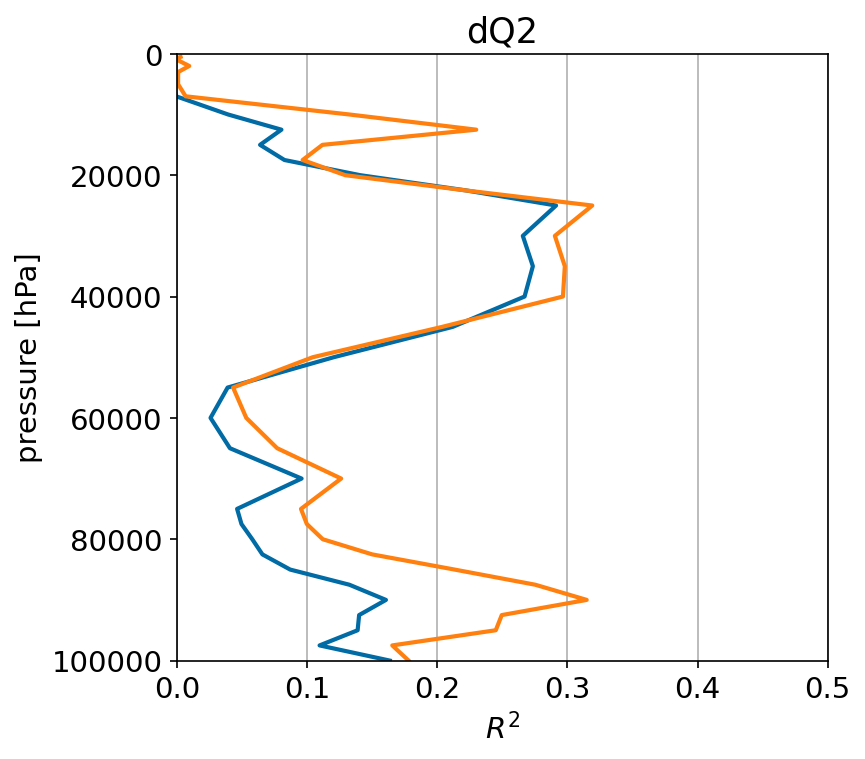

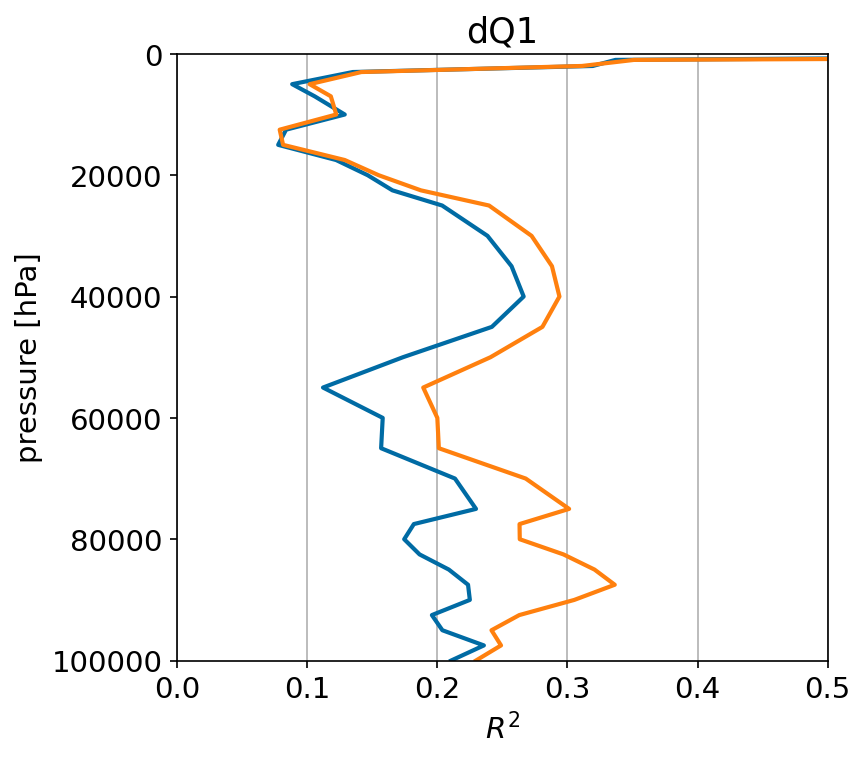

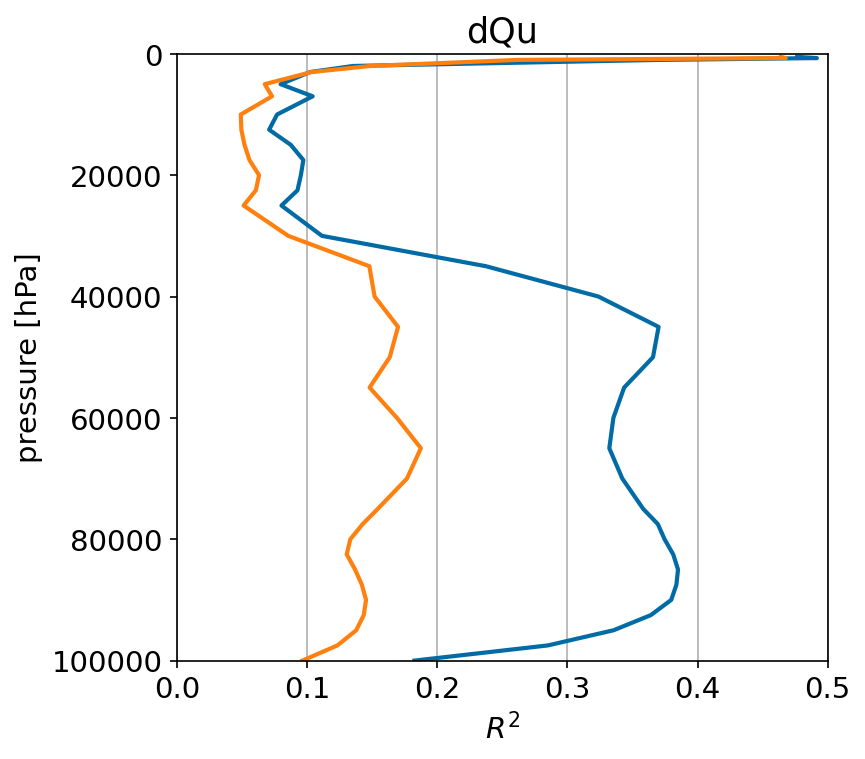

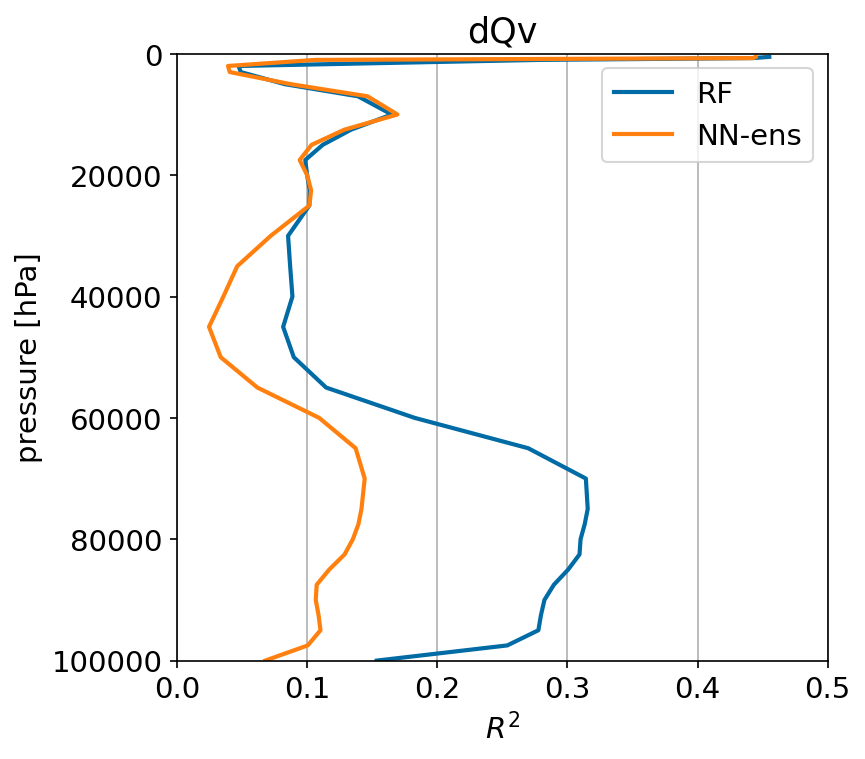

In [9]:
for var in R2_VARS:
    plot_R2_cases(diags[f"pressure_level-R2-{var}"].sel(cases=['nudged_prescribed_sfc_rad_precip_RF', 'nudged_prescribed_sfc_rad_precip_NN']))

In [7]:
# def plot_R2_all_vars(da):
#     fig, ax = plt.subplots(1, 1)
#     h = da.plot(y='pressure', hue='cases', yincrease=False, ax=ax, lw=2)
#     plt.legend(h, ['nudging-RF', 'nudging-prescribed-RF', 'nudging-prescribed-NN'], loc=1)
#     ax.set_xlim([0, 0.5])
#     ax.set_ylim([1.0e5, 0])
#     ax.set_ylabel('pressure [hPa]')
#     ax.set_xlabel('$R^{2}$')
#     ax.set_title(da.name.split('R2-')[1])
#     ax.grid(axis='x')
#     fig.tight_layout()
#     fig.set_size_inches([6, 6])
#     fig.set_dpi(150)
#     fig.savefig(os.path.join(OUTPUTDIR, f"{da.name}.png"))